In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import plotting
from utils import cloud_detection
import pandas as pd

path_file = "/Users/diego/Desktop/cloudy.npy"

image = np.load(path_file)

image = image[:,:,:13]  # Keep only the first 13 bands

np.save(path_file, image)

rgb_image = image[:,:,[3,2,1]]  # Extract RGB bands

/opt/anaconda3/envs/SpaceChallenges/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


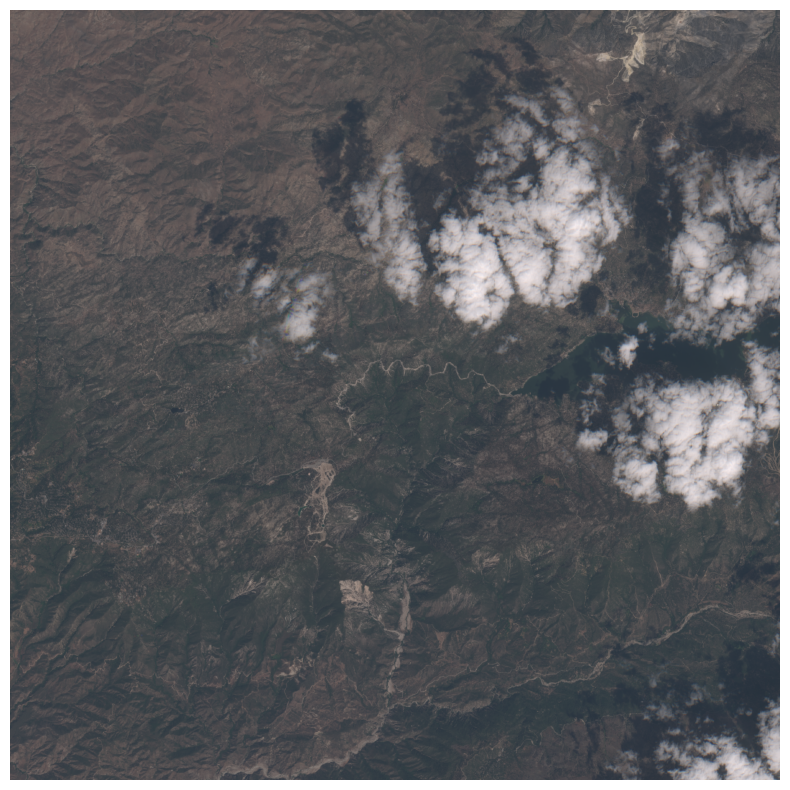

In [4]:
def stretch(band, lower=2, upper=98):
    """Realza contraste usando percentiles."""
    p_low, p_high = np.percentile(band, (lower, upper))
    return np.clip((band - p_low) / (p_high - p_low), 0, 1)

# Leer y mejorar cada banda
b2 = image[:,:,1]  # Banda azul
b3 = image[:,:,2]  # Banda verde
b4 = image[:,:,3]  # Banda roja

# Opcional: compensar bruma o bajo contraste
gamma = 2  # >1 aclara sombras y realza color
b2 = b2 ** (1/gamma)
b3 = b3 ** (1/gamma)
b4 = b4 ** (1/gamma)

# Combinar en RGB
rgb = np.dstack((b4, b3, b2))

# Mostrar
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.axis('off')
plt.show()


In [5]:
res, mask, perc = cloud_detection.is_cloudy(path_file)

Tile cloudy.npy is not cloudy (only 13.2% of pixels are cloudy).


In [6]:
# Plot mask over rgb image

plotting.create_rgb_visualization(image, os.getcwd(), job_id="test_job")

Processing RGB image: test_job


True

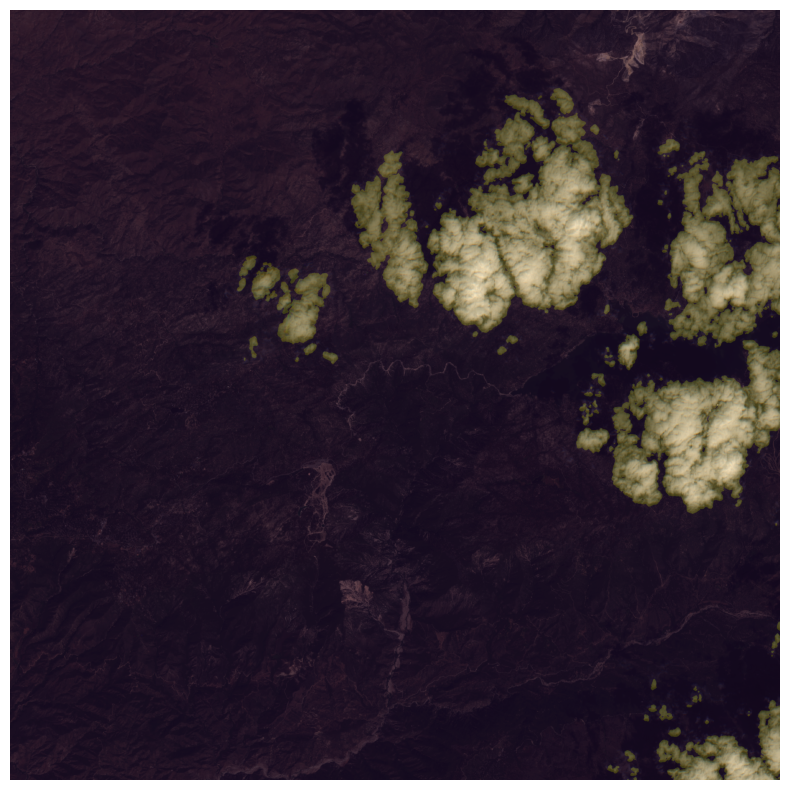

In [7]:
rgb_image_path = os.path.join(os.getcwd(), "test_job_rgb.png")

# Plot mask over rgb image

def plot_mask_on_rgb(rgb_image, mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.imshow(mask, alpha=0.2) 
    plt.axis("off")
    plt.show()

plot_mask_on_rgb(rgb_image, mask)

In [8]:
job = "dcd09b02-1974-4d73-8dff-6adb735911f1"
metadata_path = f"/Users/diego/Documents/FirePrediction/server/data/METADATA/{job}_metadata.xlsx"

In [9]:
metadata = pd.read_excel(metadata_path)
metadata

tile_number                                          tile_name  \
0             1   dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, 0)   
1             2  dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, ...   
2             3  dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, ...   
3             4  dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, ...   
4             5  dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, ...   
..          ...                                                ...   
95           96  dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(230...   
96           97  dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(230...   
97           98  dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(230...   
98           99  dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(230...   
99          100  dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(230...   

   tile_coordinates  cloud_percentage  cloud?  vegetation_percentage  forest?  
0            (0, 0)          0.000000   False               4.661560      0.0  
1          (0, 256)          0.000000   False              17.202759      1.0  
2          (0, 512)          0.000000   False              12.889099      0.0  
3          (0, 768)          0.000000   False              30.058289      1.0  
4         (0, 1024)          0.000000   False              70.787048      1.0  
..              ...               ...     ...                    ...      ...  
95     (2304, 1280)          0.000000   False              97.360229      1.0  
96     (2304, 1536)          0.000000   False              76.571655      1.0  
97     (2304, 1792)          0.049774   False              31.987000      1.0  
98     (2304, 2048)          0.460358   False               6.518555      0.0  
99     (2304, 2304)          0.799744    True                    NaN      NaN  

[100 rows x 7 columns]

In [10]:
def create_cloud_mask_visualization(image_data, output_folder, metadata_path, job_id=None):
    """
    Combina todos los tiles en una sola imagen grande y muestra:
    - Imagen RGB completa
    - Imagen RGB con máscara de nubes encima
    """
    try:
        print(f"Processing cloud image for: {job_id}")

        metadata = pd.read_excel(metadata_path)
        CLOUD_MASK_FOLDER = os.path.join("/Users/diego/Documents/FirePrediction/server/data", "CLOUD_IMAGES")
        TILES_IMAGES_PATH = os.path.join("/Users/diego/Documents/FirePrediction/server/data", "TILES_IMAGES")

        # --- 1. Determinar tamaño de la grilla ---
        # Suponiendo que las coordenadas son tipo "(row,col)"
        coords = [eval(c) for c in metadata['tile_coordinates']]
        rows = sorted(set(r for r, _ in coords))
        cols = sorted(set(c for _, c in coords))

        tile_dict_rgb = {}
        tile_dict_mask = {}
        tile_dict_rgb_display = {}

        # --- 2. Cargar todos los tiles ---
        for i in range(metadata.shape[0]):
            coord = eval(metadata['tile_coordinates'][i])  # (row, col)
            tile_path = os.path.join(TILES_IMAGES_PATH, f"{job}_tile_{metadata['tile_coordinates'][i]}.npy")
            cloud_mask_path = os.path.join(CLOUD_MASK_FOLDER, f"{job}_{metadata['tile_coordinates'][i]}_cloud_mask.npy")

            is_cloudy = metadata['cloud?'][i]
            perc_cloud = metadata['cloud_percentage'][i]

            tile = np.load(tile_path)

            if perc_cloud > 0.4:
                # RED tile
                rgb_tile = np.zeros_like(tile[:,:,:3])  # Create a red tile
                #rgb_tile[..., 0] = 255  # Set red channel to 255
            else:
                rgb_tile = tile[:,:,[3,2,1]]  # Extract RGB bands

                # Do gamma correction
                gamma = 1.2  # >1 aclara sombras y realza color
                rgb_tile = np.power(rgb_tile * 255.0, gamma) / 255.0

            rgb_display = tile[:,:,[3,2,1]]  # Extract RGB bands for display
            gamma = 1.2  # >1 aclara sombras y realza color
            rgb_display = np.power(rgb_display * 255.0, gamma) / 255.0
            cloud_mask = np.load(cloud_mask_path)
            
            tile_dict_rgb[coord] = rgb_tile
            tile_dict_mask[coord] = cloud_mask
            tile_dict_rgb_display[coord] = rgb_display

        # --- 3. Reconstruir la imagen grande ---
        full_rgb_rows = []
        full_mask_rows = []
        full_rgb_display_rows = []
        for r in rows:
            rgb_row = [tile_dict_rgb[(r,c)] for c in cols]
            mask_row = [tile_dict_mask[(r,c)] for c in cols]
            rgb_display_row = [tile_dict_rgb_display[(r,c)] for c in cols]
            full_rgb_rows.append(np.hstack(rgb_row))
            full_mask_rows.append(np.hstack(mask_row))
            full_rgb_display_rows.append(np.hstack(rgb_display_row))

        full_rgb = np.vstack(full_rgb_rows)
        full_mask = np.vstack(full_mask_rows)
        full_rgb_display = np.vstack(full_rgb_display_rows)

        # --- 4. Visualizar ---
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(full_rgb)
        ax[0].set_title("Original RGB Image")
        ax[0].axis("off")

        ax[1].imshow(full_rgb_display)
        ax[1].imshow(full_mask, alpha=0.2)
        ax[1].set_title("Cloud Mask Overlay")
        ax[1].axis("off")
        plt.show()

    except Exception as e:
        print(f"  ✗ Error processing cloud mask for {job_id}: {e}")
        return False

    return True


Processing cloud image for: test_job


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.4449348].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0322507..2.9282954].


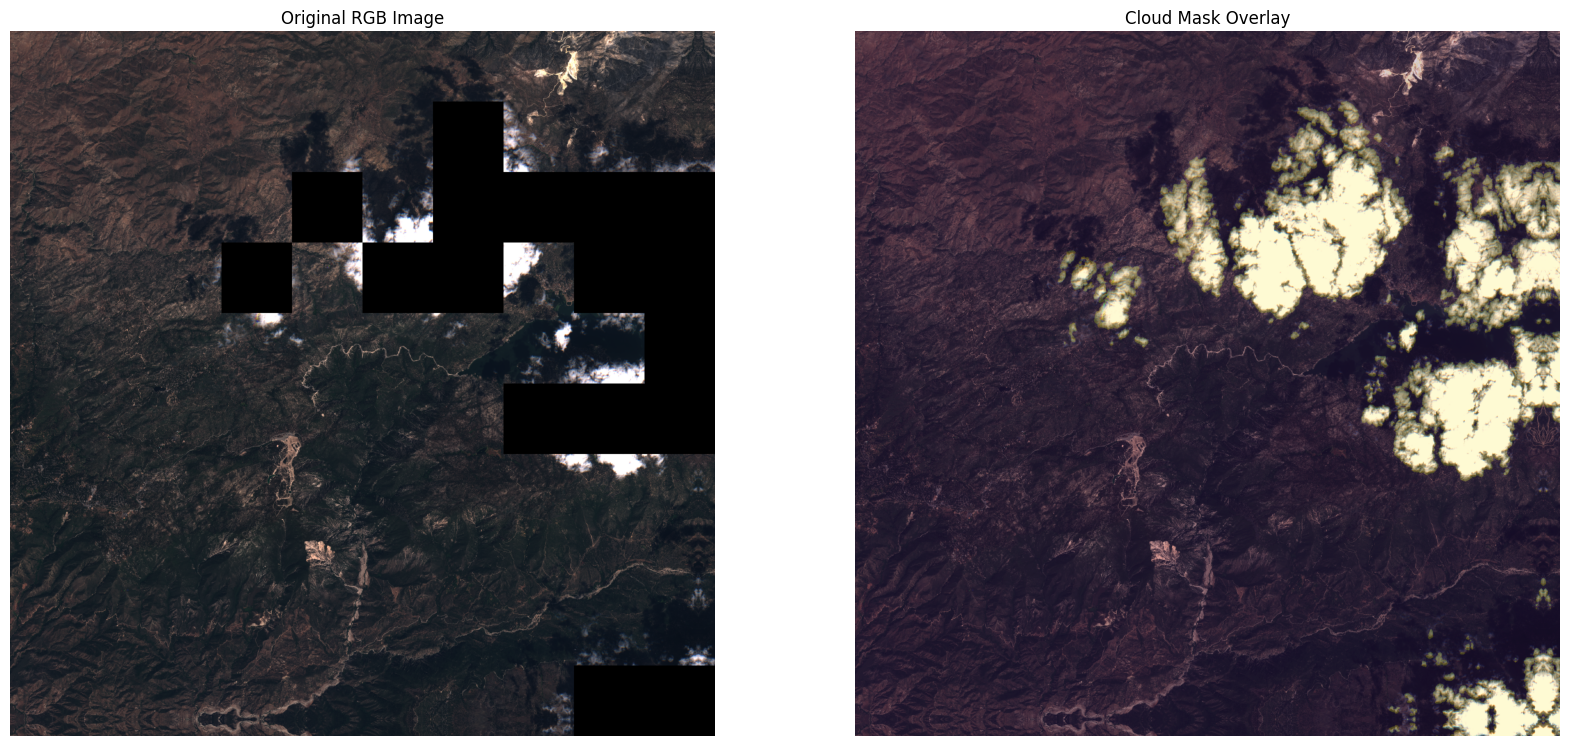

True

In [11]:
create_cloud_mask_visualization(image, os.getcwd(), metadata_path, job_id="test_job")

In [12]:
def ndvi_veg_detector(image_data, job_id, file_name=None, ndvi_threshold=0.3, min_veg_percentage=15.0):
    """
    Filter .npy files using NDVI threshold for vegetation detection
    
    Args:
        input_folder (str): Path to folder containing .npy files
        ndvi_threshold (float): NDVI threshold (typically 0.2-0.3)
        min_veg_percentage (float): Minimum percentage of vegetation pixels required (0-100)
    """
    try:

        print(f"Processing NDVI of {file_name}")

        nir = image_data[..., 7].astype(np.float32)
        red = image_data[..., 3].astype(np.float32)

        ndvi = np.divide(nir - red, nir + red,
                        out=np.zeros_like(nir), where=(nir + red) != 0)

        print("NDVI calculated")

        total_pixels = ndvi.size
        
        veg_pixels = np.sum(ndvi > ndvi_threshold)
        veg_percentage = (veg_pixels / total_pixels) * 100

        print(f"Vegetation percentage: {veg_percentage:.2f}% of tile {file_name}")

        is_forest = False
            
        # Keep if enough vegetation percentage
        if veg_percentage >= min_veg_percentage:
            is_forest = True
            return True, is_forest, veg_percentage
        else:
            print(f"  No enought vegetation {file_name} ({veg_percentage:.2f}% < {min_veg_percentage}%)")
            return True, is_forest, veg_percentage

                
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return False, False, 0.0

In [13]:
for i in range(metadata.shape[0]):
    TILES_IMAGES_PATH = os.path.join("/Users/diego/Documents/FirePrediction/server/data", "TILES_IMAGES")
    file_name = os.path.join(TILES_IMAGES_PATH, f"{job}_tile_{metadata['tile_coordinates'][i]}.npy")
    image_data = np.load(os.path.join(TILES_IMAGES_PATH, file_name))

    # Execute NDVI vegetation detector
    is_valid, is_forest, veg_percentage = ndvi_veg_detector(image_data, job_id=job, file_name=file_name)
    print("Information about NDVI")
    print(f"  Valid: {is_valid}")
    print(f"  Is Forest: {is_forest}")
    print(f"  Vegetation Percentage: {veg_percentage:.2f}%")

Processing NDVI of /Users/diego/Documents/FirePrediction/server/data/TILES_IMAGES/dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, 0).npy
NDVI calculated
Vegetation percentage: 4.66% of tile /Users/diego/Documents/FirePrediction/server/data/TILES_IMAGES/dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, 0).npy
  No enought vegetation /Users/diego/Documents/FirePrediction/server/data/TILES_IMAGES/dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, 0).npy (4.66% < 15.0%)
Information about NDVI
  Valid: True
  Is Forest: False
  Vegetation Percentage: 4.66%
Processing NDVI of /Users/diego/Documents/FirePrediction/server/data/TILES_IMAGES/dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, 256).npy
NDVI calculated
Vegetation percentage: 17.20% of tile /Users/diego/Documents/FirePrediction/server/data/TILES_IMAGES/dcd09b02-1974-4d73-8dff-6adb735911f1_tile_(0, 256).npy
Information about NDVI
  Valid: True
  Is Forest: True
  Vegetation Percentage: 17.20%
Processing NDVI of /Users/diego/Documents/FirePrediction/

In [14]:
def create_forest_picture(output_folder, metadata_path, job_id=None):
    """
    Create a forest picture from the image data.

    Args:
        image_path (str): Path to the input image
        output_folder (str): Path to the output folder
        metadata_path (str): Path to the metadata file
        job_id (str, optional): Job ID for tracking purposes

    Returns:
        bool: True if successful, False otherwise
    """
    try:
        print(f"Processing forest picture for: {job_id}")

        print("Loading metadata...")

        metadata = pd.read_excel(metadata_path)
        CLOUD_MASK_FOLDER = os.path.join("/Users/diego/Documents/FirePrediction/server/data", "CLOUD_IMAGES")
        TILES_IMAGES_PATH = os.path.join("/Users/diego/Documents/FirePrediction/server/data", "TILES_IMAGES")

        coords = [eval(c) for c in metadata['tile_coordinates']]
        rows = sorted(set(r for r, _ in coords))
        cols = sorted(set(c for _, c in coords))

        tile_dict_rgb = {}
        tile_dict_ndvi = {}

        for i in range(metadata.shape[0]):

            is_cloudy = metadata['cloud?'][i]
            is_forest = metadata['forest?'][i]

            coord = eval(metadata['tile_coordinates'][i])  # (row, col)

            if not is_cloudy and is_forest:

                tile_path = os.path.join(TILES_IMAGES_PATH, f"{job}_tile_{metadata['tile_coordinates'][i]}.npy")

                tile = np.load(tile_path)

                # Calculate ndvi for display purposes

                nir = tile[..., 7].astype(np.float32)
                red = tile[..., 3].astype(np.float32)

                ndvi = np.divide(nir - red, nir + red,
                                out=np.zeros_like(nir), where=(nir + red) != 0)

                rgb = tile[:,:,[3,2,1]]  # Extract RGB bands for display
                gamma = 1.2  # >1 aclara sombras y realza color
                rgb = np.power(rgb * 255.0, gamma) / 255.0

            else:
                if is_cloudy:
                    # Black
                    rgb = np.zeros((256, 256, 3), dtype=np.float32)
                else:
                    # Red
                    rgb = np.zeros((256, 256, 3), dtype=np.float32)
                    rgb[..., 0] = 255  # Set red channel to 255
                ndvi = np.zeros((256, 256), dtype=np.float32)

            tile_dict_rgb[coord] = rgb
            tile_dict_ndvi[coord] = ndvi

        # Display everything
        full_rgb_rows = []
        full_ndvi_rows = []

        for r in rows:
            rgb_row = [tile_dict_rgb[(r,c)] for c in cols]
            ndvi_row = [tile_dict_ndvi[(r,c)] for c in cols]
            full_rgb_rows.append(np.hstack(rgb_row))
            full_ndvi_rows.append(np.hstack(ndvi_row))

        full_rgb = np.vstack(full_rgb_rows)
        full_ndvi = np.vstack(full_ndvi_rows)

        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(full_rgb)
        ax[0].set_title("Original RGB Image")
        ax[0].axis("off")

        ax[1].imshow(full_ndvi, cmap="RdYlGn")
        ax[1].set_title("NDVI Image")
        ax[1].axis("off")
        plt.show()
        

    except Exception as e:
        print(f"  ✗ Error processing forest picture for {job_id}: {e}")
        return False

    return True

Processing forest picture for: test_job
Loading metadata...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


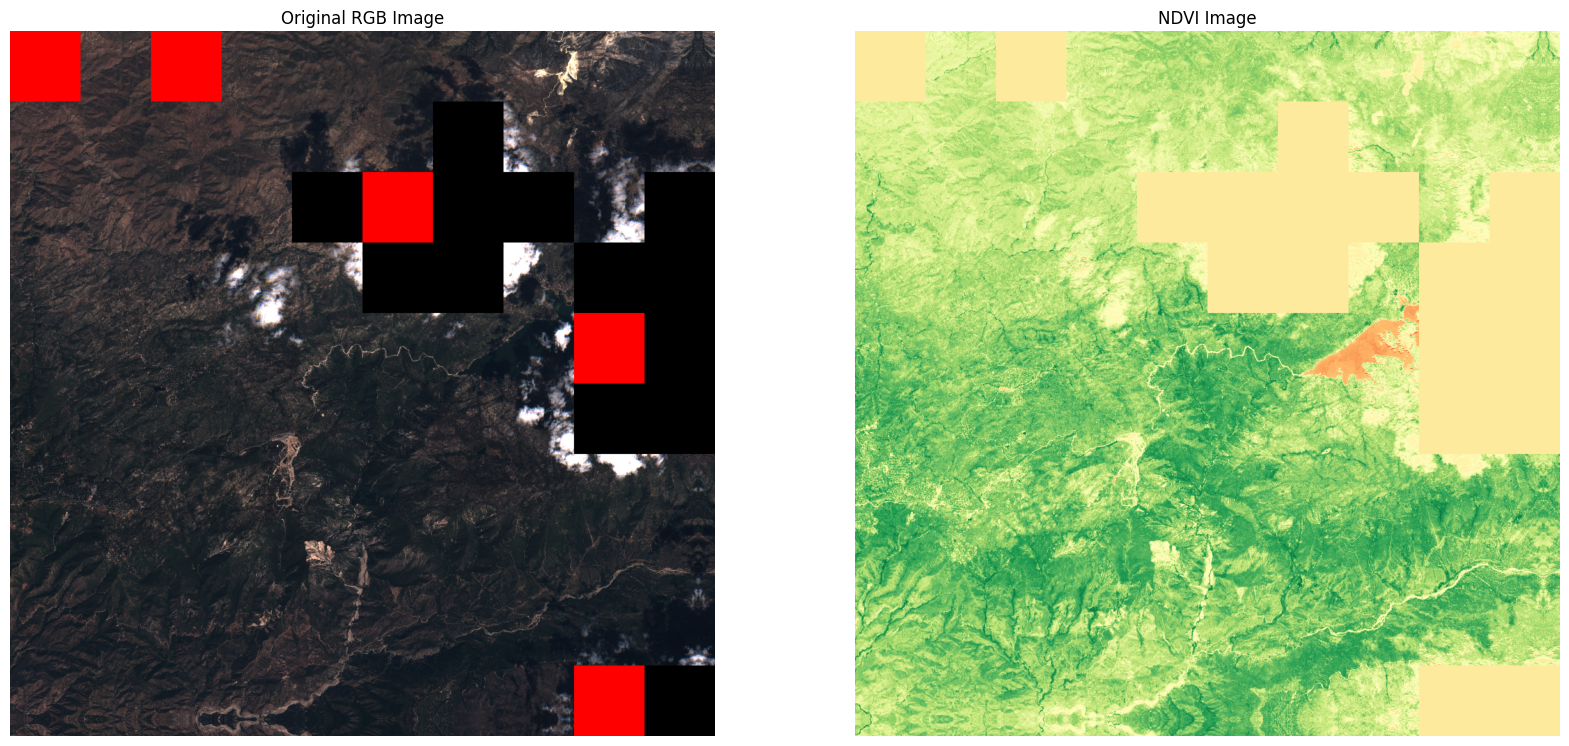

True

In [15]:
create_forest_picture(os.getcwd(), metadata_path, job_id="test_job")